# Unsupervised learning

### The goal of the notebook is to research some models x features sets out of *.pcaps

In [44]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import collections
import seaborn as sns
import pprint
import os
import ipywidgets
import warnings

import pyshark
import networkx as nx

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import umap

from itertools import product

# PATH change to access library cyberlib
import sys
sys.path.append('/home/benjamin/Folders_Python/Cyber/libs')
import cyberlib as cbl

# to allow PyShark to run in Jupyter notebooks
import nest_asyncio
nest_asyncio.apply()

In [45]:
# logging set-up

lg = cbl.GetLogger('/home/benjamin/Folders_Python/Cyber/logs/unsupervised_learning.log')
logger = lg.get_custom_logger()

# start your engine
logger.info("-------- new run --------")

### Get the *.pcap to play with

In [46]:
DFNAME = 'exemple'

PCAPFILE = '/home/benjamin/Folders_Python/Cyber/data/input_pcaps/' + DFNAME + '.pcap'

In [47]:
capture = pyshark.FileCapture(
    input_file=PCAPFILE,
    use_ek=False
)

logger.info(f'-- created a capture object in PyShark with pcap file = {PCAPFILE} --')

In [48]:
pp = pprint.PrettyPrinter(indent=4)

for id in range(5):
    p = cbl.PyPacket(capture[id])
    pp.pprint(p.data)
    print('-------------')

{   'ETH': {   'dst': '9c:9d:7e:91:92:4b',
               'src': '6c:88:14:eb:a4:5c',
               'type': '0x0800'},
    'IP': {   'dst': '192.168.31.1',
              'flags': '0x02',
              'hdr_len': '20',
              'id': '0xf987',
              'len': '70',
              'proto': '17',
              'src': '192.168.31.236',
              'ttl': '64',
              'version': '4'},
    'TIMESTAMP': {'ts': datetime.datetime(2023, 6, 13, 18, 58, 42, 19861)},
    'UDP': {   'dstport': '53',
               'length': '50',
               'payload': 'd6:91:01:00:00:01:00:00:00:00:00:00:0c:64:65:74:65:63:74:70:6f:72:74:61:6c:07:66:69:72:65:66:6f:78:03:63:6f:6d:00:00:01:00:01',
               'srcport': '40271',
               'stream': '0',
               'time_delta': '0.000000000',
               'time_relative': '0.000000000'}}
-------------
{   'ETH': {   'dst': '9c:9d:7e:91:92:4b',
               'src': '6c:88:14:eb:a4:5c',
               'type': '0x0800'},
    'IP': {  

### Choice of features

We will look at Ethernet packets part of a TCP conversation

Features at TCP level : source port, destination port, sequence number, acknowledgement number, flags, header length, total length, time delta since last packet, time delta since first packet

Features at IP level : source IP, destination IP, flags, header length, length, identification, ttl, version

Features at ETH level : None

In [49]:
DIRDATAFRAMES = '/home/benjamin/Folders_Python/Cyber/data/dataframes/'
filename = DIRDATAFRAMES + 'df_raw_' + DFNAME + '.pkl'

if os.path.isfile(filename):
    df_raw = pd.read_pickle(filename)
    logger.info('read an existing dataframe for unsupervised learning')
else:
    df_raw = cbl.GetTCPDataframeFromFileCapture(filecapture=capture).dataframe
    df_raw.to_pickle(filename)
    logger.info('created and wrote a dataframe for unsupervised learning')

2293it [02:08, 17.81it/s]                    


In [50]:
df_raw

,ETH_dst,ETH_src,IP_id,IP_flags,IP_src,IP_dst,TCP_flags,IP_version,IP_hdr_len,IP_len,...,TCP_srcport,TCP_dstport,TCP_stream,TCP_len,TCP_seq,TCP_ack,TCP_hdr_len,TCP_time_relative,TCP_time_delta,TIMESTAMP_ts
0,9c:9d:7e:91:92:4b,6c:88:14:eb:a4:5c,0x7804,0x02,192.168.31.236,34.107.221.82,0,4.0,20.0,60.0,...,38988.0,80.0,0.0,0.0,0.0,0.0,40.0,0.000000,0.000000,2023-06-13 18:58:42.068363
1,6c:88:14:eb:a4:5c,9c:9d:7e:91:92:4b,0x0000,0x02,34.107.221.82,192.168.31.236,1,4.0,20.0,60.0,...,80.0,38988.0,0.0,0.0,0.0,1.0,40.0,0.020534,0.020534,2023-06-13 18:58:42.088897
2,9c:9d:7e:91:92:4b,6c:88:14:eb:a4:5c,0x7805,0x02,192.168.31.236,34.107.221.82,2,4.0,20.0,52.0,...,38988.0,80.0,0.0,0.0,1.0,1.0,32.0,0.020578,0.000044,2023-06-13 18:58:42.088941
3,9c:9d:7e:91:92:4b,6c:88:14:eb:a4:5c,0x7806,0x02,192.168.31.236,34.107.221.82,3,4.0,20.0,345.0,...,38988.0,80.0,0.0,293.0,1.0,1.0,32.0,0.020748,0.000170,2023-06-13 18:58:42.089111
4,9c:9d:7e:91:92:4b,6c:88:14:eb:a4:5c,0xb949,0x02,192.168.31.236,34.117.237.239,0,4.0,20.0,60.0,...,48186.0,443.0,1.0,0.0,0.0,0.0,40.0,0.000000,0.000000,2023-06-13 18:58:42.104505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,6c:88:14:eb:a4:5c,9c:9d:7e:91:92:4b,0x8e91,0x02,34.250.170.156,192.168.31.236,4,4.0,20.0,52.0,...,443.0,54220.0,11.0,0.0,9800.0,10310.0,32.0,38.751485,0.000032,2023-06-13 18:59:29.790467
1809,9c:9d:7e:91:92:4b,6c:88:14:eb:a4:5c,0x0000,0x02,192.168.31.236,34.250.170.156,2,4.0,20.0,52.0,...,54220.0,443.0,11.0,0.0,10310.0,9801.0,32.0,38.751505,0.000020,2023-06-13 18:59:29.790487
1810,6c:88:14:eb:a4:5c,9c:9d:7e:91:92:4b,0x50d9,0x02,35.174.110.81,192.168.31.236,2,4.0,20.0,52.0,...,443.0,43722.0,13.0,0.0,514661.0,32358.0,32.0,38.536184,0.089146,2023-06-13 18:59:29.843419
1811,6c:88:14:eb:a4:5c,9c:9d:7e:91:92:4b,0x50da,0x02,35.174.110.81,192.168.31.236,4,4.0,20.0,52.0,...,443.0,43722.0,13.0,0.0,514661.0,32390.0,32.0,38.541509,0.005325,2023-06-13 18:59:29.848744


### Preprocessing : ordinal encoding, normalization

In [51]:
# ordinal encoding with Pandas

columns_to_encode_as_ordinal = ['ETH_dst', 'ETH_src', 'IP_id', 'IP_flags', 'IP_src', 'IP_dst']

df_ord = pd.DataFrame()
for c in columns_to_encode_as_ordinal:
    codes, _ = pd.factorize(df_raw[c])
    df_sup = pd.DataFrame(data={ c : list(codes) })
    df_ord = pd.concat([df_ord, df_sup], axis=1)
    
df = df_raw.drop(columns=columns_to_encode_as_ordinal)
df.reset_index(drop=True)

df = pd.concat([df, df_ord], axis=1)

columns_to_drop = ['TIMESTAMP_ts']
df.drop(columns=columns_to_drop, inplace=True)

df

,TCP_flags,IP_version,IP_hdr_len,IP_len,IP_ttl,IP_proto,TCP_srcport,TCP_dstport,TCP_stream,TCP_len,...,TCP_ack,TCP_hdr_len,TCP_time_relative,TCP_time_delta,ETH_dst,ETH_src,IP_id,IP_flags,IP_src,IP_dst
0,0,4.0,20.0,60.0,64.0,6.0,38988.0,80.0,0.0,0.0,...,0.0,40.0,0.000000,0.000000,0,0,0,0,0,0
1,1,4.0,20.0,60.0,120.0,6.0,80.0,38988.0,0.0,0.0,...,1.0,40.0,0.020534,0.020534,1,1,1,0,1,1
2,2,4.0,20.0,52.0,64.0,6.0,38988.0,80.0,0.0,0.0,...,1.0,32.0,0.020578,0.000044,0,0,2,0,0,0
3,3,4.0,20.0,345.0,64.0,6.0,38988.0,80.0,0.0,293.0,...,1.0,32.0,0.020748,0.000170,0,0,3,0,0,0
4,0,4.0,20.0,60.0,64.0,6.0,48186.0,443.0,1.0,0.0,...,0.0,40.0,0.000000,0.000000,0,0,4,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,4,4.0,20.0,52.0,229.0,6.0,443.0,54220.0,11.0,0.0,...,10310.0,32.0,38.751485,0.000032,1,1,1764,0,9,1
1809,2,4.0,20.0,52.0,64.0,6.0,54220.0,443.0,11.0,0.0,...,9801.0,32.0,38.751505,0.000020,0,0,1,0,0,9
1810,2,4.0,20.0,52.0,235.0,6.0,443.0,43722.0,13.0,0.0,...,32358.0,32.0,38.536184,0.089146,1,1,1765,0,11,1
1811,4,4.0,20.0,52.0,235.0,6.0,443.0,43722.0,13.0,0.0,...,32390.0,32.0,38.541509,0.005325,1,1,1766,0,11,1


In [52]:
# the rest of the preprocessing with a scikit learn pipeline

pipe = Pipeline(
    [ ('normalize', StandardScaler() )]
)

In [53]:
X = df.to_numpy()
X_norm = pipe.fit_transform(X)

In [54]:
X_norm

array([[-3.80287987,  0.        ,  0.        , ..., -0.21903625,
        -1.03597239, -1.04162964],
       [-2.2415979 ,  0.        ,  0.        , ..., -0.21903625,
        -0.8455996 , -0.82905934],
       [-0.68031592,  0.        ,  0.        , ..., -0.21903625,
        -1.03597239, -1.04162964],
       ...,
       [-0.68031592,  0.        ,  0.        , ..., -0.21903625,
         1.05812829, -0.82905934],
       [ 2.44224804,  0.        ,  0.        , ..., -0.21903625,
         1.05812829, -0.82905934],
       [-0.68031592,  0.        ,  0.        , ..., -0.21903625,
        -1.03597239,  1.29664365]])

In [55]:
def viz3d(X_embedding, titre='visu 3D'):
    """Utility function to plot a 3D picture

    Args:
        X_embedding (_type_): _description_
    """
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')
    
    xs = X_embedding[:,0]
    ys = X_embedding[:,1]
    zs = X_embedding[:,2]
    
    ax.scatter3D(xs, ys, zs)
    ax.set_title(titre)
    
    plt.show()
    
    return fig, ax

### Vizualization : PCA, t-SNE

Variance per principal component : ['43.7%', '15.2%', '9.7%']%


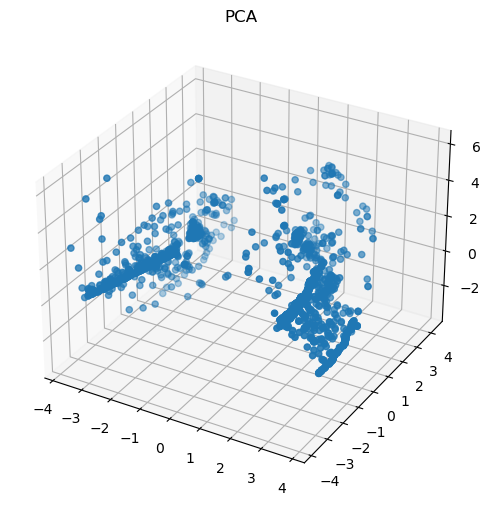

In [56]:
pca = PCA(
    n_components = 3
)

X_new = pca.fit_transform(X_norm)

expl = [ r*100 for r in pca.explained_variance_ratio_ ]
expl_s = [ f'{e:.1f}%' for e in expl ]
print(f'Variance per principal component : {expl_s}%')

viz3d(X_new, 'PCA')
plt.show()

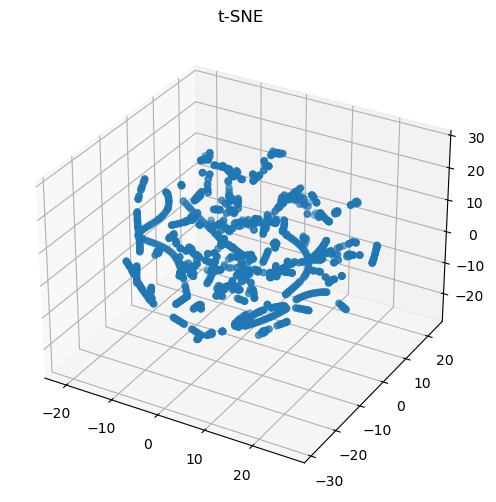

In [57]:
X_new = TSNE(
    n_components=3, 
    learning_rate='auto',
    perplexity=10  # reltaed to the number of neighbors used in other manifold learning algorithms. Highly sensitve parameter.
    ).fit_transform(X_norm)

viz3d(X_new, 't-SNE')
plt.show()

### Clustering

k-means

In [58]:
# finding a good number of clusters

MAX_CLUSTERS = 100
range_clusters = range(2, MAX_CLUSTERS+1)

silhouette = np.zeros(shape=(MAX_CLUSTERS-1))

for n_clusters in range_clusters:
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        init='k-means++', # educated attempt to have a good initialization
        n_init=1  # because k-means++
        )
    labels = kmeans.fit_predict(X_norm)
    silhouette[n_clusters-2] = silhouette_score(X_norm, labels)
    print(f'Silhouette score for {n_clusters} clusters = {silhouette[n_clusters-2]}')
    
n_cluster_opt = np.argmax(silhouette) + 2
print(f'Nb clusters retenu = {n_cluster_opt}')

Silhouette score for 2 clusters = 0.4347590833503563
Silhouette score for 3 clusters = 0.3647420030246806
Silhouette score for 4 clusters = 0.30821396875008417
Silhouette score for 5 clusters = 0.3161193498008061
Silhouette score for 6 clusters = 0.27947569849932485
Silhouette score for 7 clusters = 0.3084836774227391
Silhouette score for 8 clusters = 0.37882086335006926
Silhouette score for 9 clusters = 0.3708970622710225
Silhouette score for 10 clusters = 0.39528152050810195
Silhouette score for 11 clusters = 0.3981556768969296
Silhouette score for 12 clusters = 0.3944339492211099
Silhouette score for 13 clusters = 0.3819373171005207
Silhouette score for 14 clusters = 0.3879430159866944
Silhouette score for 15 clusters = 0.4045283239799631
Silhouette score for 16 clusters = 0.39981568832283787
Silhouette score for 17 clusters = 0.4043221123274347
Silhouette score for 18 clusters = 0.4057098524482137
Silhouette score for 19 clusters = 0.41184717428407347
Silhouette score for 20 cluste

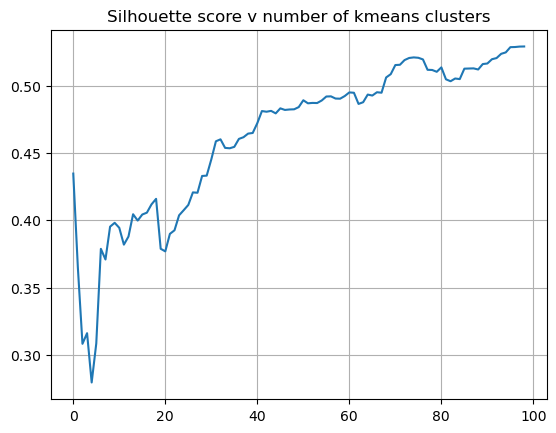

In [59]:
fig, ax = plt.subplots()

ax.plot(silhouette)
ax.grid(True)
ax.set_title('Silhouette score v number of kmeans clusters')
plt.show()

In [60]:
kmeans = KMeans(
    n_clusters=n_cluster_opt,
    random_state=0,
    init='k-means++', # educated attempt to have a good initialization
    n_init=1  # because k-means++
)

In [61]:
def visu3d(X_norm=X_norm, model=None, labels=None, titre='Visu 3d'):
    """Utility function to plot the 3d PCA projection of the trained model with clusters labels

    Args:
        X_norm (_type_, optional): _description_. Defaults to X_norm.
        model (_type_, optional): _description_. Defaults to None.
        labels (_type_, optional): _description_. Defaults to None.
    """
    
    unique_labels = np.unique(labels)
    
    pca = PCA(n_components = 3)
    X_embedding = pca.fit_transform(X_norm)
    
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')

    xs = X_embedding[:,0]
    ys = X_embedding[:,1]
    zs = X_embedding[:,2]

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    c = [ colors[labels[i]] if labels[i] >= 0 else [0,0,0,1] for i in range(len(labels)) ]
        
    ax.scatter3D(xs, ys, zs, color=c)
    n_clusters = len(set(unique_labels)) - (1 if -1 in labels else 0)
    titre = titre + f' {n_clusters} clusters'
    ax.set_title(titre)
        
    plt.show()
    
    return fig, ax

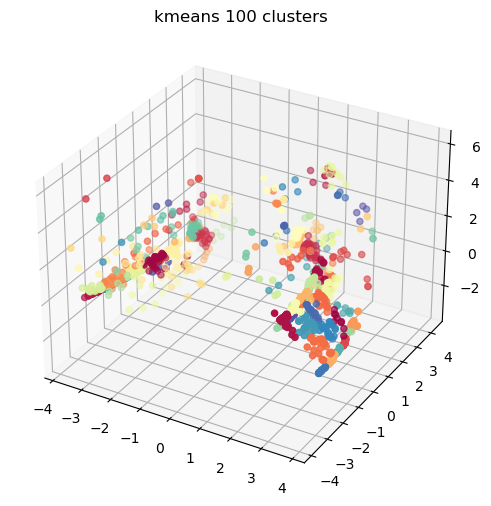

In [62]:
labels = kmeans.fit_predict(X_norm)

fig, ax = visu3d(
    X_norm=X_norm,
    model=kmeans,
    labels=kmeans.fit_predict(X_norm),
    titre=f'kmeans'
)

DBSCAN

In [63]:
# finding a good pair of Epsilon x Min_samples parameters

# epsilons
distances = pairwise_distances(X_norm, X_norm).flatten() # compute all the euclidian distances between two points in X_norm
dmax = np.max(distances)
print(f'max distance between two points in feature space = {dmax}')
N_EPSILONS = 5
epsilons_range = np.linspace(dmax/100.0, dmax/20.0, num=N_EPSILONS)
# print(epsilons_range)

# minimum samples
n_samples = X_norm.shape[0]
N_MIN_SAMPLES = 10
n_min_samples = np.max( [2,n_samples/2000] )
n_max_samples = np.max( [n_samples/100, n_min_samples+1] )
min_samples_range = np.linspace(n_min_samples, n_max_samples, num=N_MIN_SAMPLES).astype('int')
# print(min_samples_range)

# silhouettes calculations
silhouette_max = -1.0

for epsilon, min_samples in product(epsilons_range, min_samples_range):
    print(f'-----------------------------------------------------')
    print(f'n_samples = {min_samples}, epsilon = {epsilon}')
    
    db = DBSCAN(
        eps=epsilon,
        min_samples=min_samples
        )
    
    labels = db.fit_predict(X_norm)
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  # number of found clusters (without -1 which is the label for noise
    n_noise_ = list(labels).count(-1)  # number of noisy points
    noise_ratio = n_noise_/n_samples
    
    print(f'number of clusters found is {n_clusters_}')
    print(f'number of noise points found is {n_noise_} out of {n_samples} total (ie {noise_ratio*100:.2f}%)')
    
    if len(set(labels)) >= 2:
        s = silhouette_score(X_norm, labels)
        print(f'Silhouette score for {n_clusters_} clusters = {s:.3f}')
    else:
        print(f'Not calulating silhouette score as only one label found')
    
    if s > silhouette_max:
        silhouette_max = s
        opt_n_clusters = n_clusters_
        opt_eps = epsilon
        opt_min_samples = min_samples
        opt_noise_ratio = noise_ratio
        
print(f'====================================================================================================')
print(f'Best silhouette score is {silhouette_max} with {opt_n_clusters} clusters and {opt_noise_ratio*100:.2f}% noise, for epsilon = {opt_eps} and min_samples = {opt_min_samples}')

max distance between two points in feature space = 20.779375760972147
-----------------------------------------------------
n_samples = 2, epsilon = 0.20779375760972146
number of clusters found is 158
number of noise points found is 301 out of 1813 total (ie 16.60%)
Silhouette score for 158 clusters = 0.396
-----------------------------------------------------
n_samples = 3, epsilon = 0.20779375760972146
number of clusters found is 101
number of noise points found is 415 out of 1813 total (ie 22.89%)
Silhouette score for 101 clusters = 0.318
-----------------------------------------------------
n_samples = 5, epsilon = 0.20779375760972146
number of clusters found is 69
number of noise points found is 555 out of 1813 total (ie 30.61%)
Silhouette score for 69 clusters = 0.235
-----------------------------------------------------
n_samples = 7, epsilon = 0.20779375760972146
number of clusters found is 52
number of noise points found is 666 out of 1813 total (ie 36.73%)
Silhouette score fo

In [64]:
print(f'Running DBSCAN with epsilon = {opt_eps} and min_samples = {opt_min_samples}.\nSilhouette score is {silhouette_max} with {opt_n_clusters} clusters and {opt_noise_ratio*100:.2f}% noise')

db = DBSCAN(
    eps=opt_eps,
    min_samples=opt_min_samples
)

labels = db.fit_predict(X_norm)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  # number of found clusters (without -1 which is the label for noise)
n_noise_ = list(labels).count(-1)  # number of noisy points
n_points = X_norm.shape[0]

print(f'=> number of clusters found is {n_clusters_}')
print(f'=> number of noise points found is {n_noise_} out of {n_points} total (ie {n_noise_/n_points*100:.2f}%)')

Running DBSCAN with epsilon = 0.20779375760972146 and min_samples = 2.
Silhouette score is 0.39638726820094605 with 158 clusters and 16.60% noise
=> number of clusters found is 158
=> number of noise points found is 301 out of 1813 total (ie 16.60%)


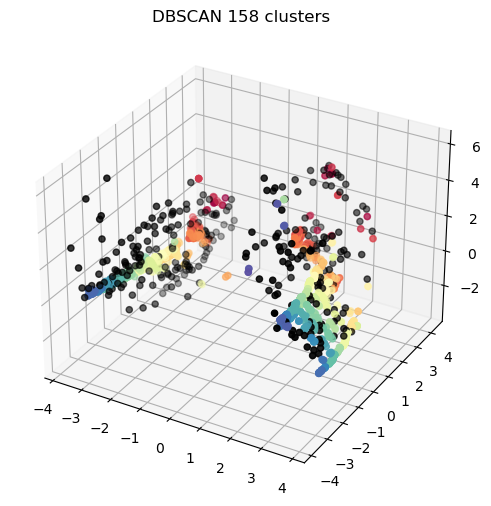

In [65]:
labels = db.fit_predict(X_norm)

fig, ax = visu3d(
    X_norm=X_norm,
    model=db,
    labels=db.fit_predict(X_norm),
    titre=f'DBSCAN'
)

### Gaussian Mixtures

In [66]:
N_MAX_GAUSSIANS = 100
ng_bics = []
bics = []

for i in range(1, N_MAX_GAUSSIANS, 5):
    n_gaussians = i+1
    gm = GaussianMixture(
        n_components=n_gaussians,
        covariance_type='full',
        random_state=42
        )
    
    labels = gm.fit_predict(X_norm)
    bic = gm.bic(X_norm)
    print(f'Model with {n_gaussians} gaussian(s) : BIC score = {bic:.0f}')
    
    ng_bics.append(n_gaussians)
    bics.append(bic)
    
opt_n_gaussians = ng_bics[np.argmin(bics)]
print(f'Best BIC score with {opt_n_gaussians}')

# BIC : https://scikit-learn.org/stable/modules/linear_model.html#aic-bic

Model with 2 gaussian(s) : BIC score = -163490
Model with 7 gaussian(s) : BIC score = -252878
Model with 12 gaussian(s) : BIC score = -261428
Model with 17 gaussian(s) : BIC score = -266468
Model with 22 gaussian(s) : BIC score = -266968
Model with 27 gaussian(s) : BIC score = -261356
Model with 32 gaussian(s) : BIC score = -265459
Model with 37 gaussian(s) : BIC score = -263242
Model with 42 gaussian(s) : BIC score = -259639
Model with 47 gaussian(s) : BIC score = -251110
Model with 52 gaussian(s) : BIC score = -242816
Model with 57 gaussian(s) : BIC score = -237713
Model with 62 gaussian(s) : BIC score = -230858
Model with 67 gaussian(s) : BIC score = -223953
Model with 72 gaussian(s) : BIC score = -216044
Model with 77 gaussian(s) : BIC score = -207377
Model with 82 gaussian(s) : BIC score = -200898
Model with 87 gaussian(s) : BIC score = -192345
Model with 92 gaussian(s) : BIC score = -185232
Model with 97 gaussian(s) : BIC score = -177009
Best BIC score with 22


Best BIC score -266968 with 22 gaussians


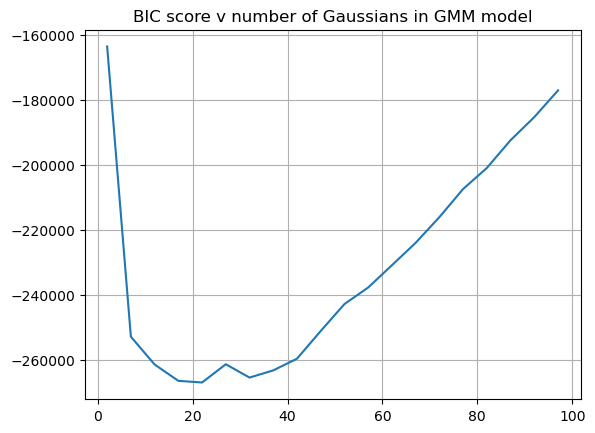

In [67]:
opt_n_gaussians = ng_bics[np.argmin(bics)]
print(f'Best BIC score {np.min(bics):.0f} with {opt_n_gaussians} gaussians')

fig, ax = plt.subplots()

ax.plot(ng_bics, bics)
ax.grid(True)
ax.set_title(f'BIC score v number of Gaussians in GMM model')
plt.show()

In [68]:
gm = GaussianMixture(
    n_components=opt_n_gaussians,
    covariance_type='full',
    random_state=42
)

labels = gm.fit_predict(X_norm)

print(f'BIC score = {gm.bic(X_norm):.2f}')

BIC score = -266968.25


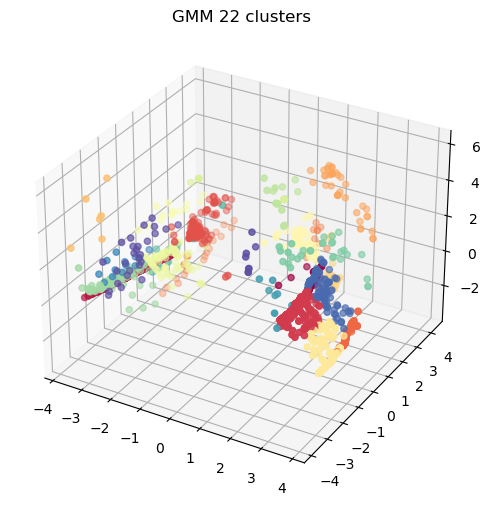

In [69]:
fig, ax = visu3d(
    X_norm=X_norm,
    model=gm,
    labels=labels,
    titre=f'GMM'
)

### UMAP : Manifold Learning => ~ visualization

In [70]:
# DOC : https://umap.scikit-tda.org/index.html

def visu_umap(
    n_neighbors=10,
    min_dist=0.1,
    # X_norm=X_norm
):
    """Utility function to use UMAP for 3D visualization

    Args:
        n_neighbors (int, optional): _description_. Defaults to 10.
        n_components (int, optional): _description_. Defaults to 3.
        min_dist (float, optional): _description_. Defaults to 0.1.
        random_state (int, optional): _description_. Defaults to 42.
    """
    
    warnings.filterwarnings("ignore")
    
    umap_instance = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=3,
        min_dist=min_dist,
        random_state=42
        )
    
    X_new = umap_instance.fit_transform(X_norm)
    
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')

    xs = X_new[:,0]
    ys = X_new[:,1]
    zs = X_new[:,2]
            
    ax.scatter3D(xs, ys, zs) #, color=c)
    titre = f'UMAP - {n_neighbors} neigbhors, {min_dist} min dist'
    ax.set_title(titre)
            
    plt.show()
    
    # return fig, ax

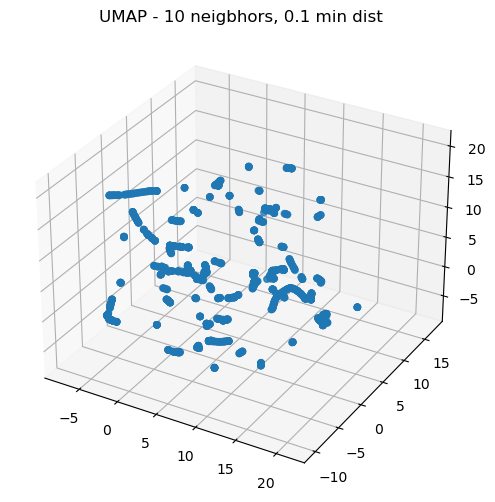

In [71]:
warnings.filterwarnings("ignore")
visu_umap()

In [72]:
ipywidgets.interact(
    visu_umap,
    n_neighbors = (5,100,10),
    min_dist = (0.1,1.0,0.05)
)

interactive(children=(IntSlider(value=10, description='n_neighbors', min=5, step=10), FloatSlider(value=0.1, d…

<function __main__.visu_umap(n_neighbors=10, min_dist=0.1)>